### 라이브러리 임포트

In [1]:
import os
import sys
import random
import warnings
import cv2
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import AveragePooling2D, BatchNormalization, ELU, Reshape, Concatenate, Activation
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# Set some parameters
IMG_WIDTH = 152
IMG_HEIGHT = 60
IMG_CHANNELS = 3

TRAIN_PATH='./unet_data/x_train_new/'
TEST_PATH ='./unet_data/x_test_new/'
MASK_TRAIN='./unet_data/y_train_new/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\tensorflow\python\f

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'1.13.1'

In [4]:
import keras
keras.__version__

'2.3.1'

### 데이터 로드

In [5]:
# #한글이름 사진 로드
from PIL import Image

#gray로 불러와야 threshold  함수 사용가능
def hangulFilePathImageRead2 (filePath ) :  
    stream = open( filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

In [6]:
train_path=os.walk(TRAIN_PATH) #raw
train_ids= next(train_path)[2]

test_path=os.walk(TEST_PATH)
test_ids = next(test_path)[2]

mask_path=os.walk(MASK_TRAIN)
mask_ids = next(mask_path)[2]

In [7]:
test_ids.sort()
train_ids.sort()
mask_ids.sort()

In [8]:
print(len(train_ids),len(mask_ids),len(test_ids))

1880 1880 600


In [9]:
#한글이름 사진 로드 - x_train
import cv2
def hangulFilePathImageRead (filePath ) :
    stream = open( filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_COLOR)  #3채널로 가져오기
#     return cv2.resize(img,(0,0),fx=4,fy=4,interpolation=cv2.INTER_LINEAR)


train_ids=[]
if __name__ == '__main__':
    os.listdir(TRAIN_PATH).sort()
    for f in os.listdir(TRAIN_PATH):  
        if f.split('.')[1] =='jpg' or f.split('.')[1]=='bmp':
            filePath = (r"./unet_data/x_train_new/"+f)
            print(filePath)
            train_ids.append(hangulFilePathImageRead(filePath))

./unet_data/x_train_new/[SEG]강병준_1_1.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_1862.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_2218.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_5481.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_5973.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_7302.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_764.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_7685.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_8136.jpg
./unet_data/x_train_new/[SEG]강병준_1_1_0_9716.jpg
./unet_data/x_train_new/[SEG]강병준_2_1.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_1632.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_331.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_3936.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_4556.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_6768.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_8011.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_8500.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_8898.jpg
./unet_data/x_train_new/[SEG]강병준_2_1_0_9207.jpg
./unet_data/x_train_new/[SEG]강병준_3_1.jpg
./unet_data/x_t

./unet_data/x_train_new/[SEG]김주리_3_1_0_1463.jpg
./unet_data/x_train_new/[SEG]김주리_3_1_0_1823.jpg
./unet_data/x_train_new/[SEG]김주리_3_1_0_1992.jpg
./unet_data/x_train_new/[SEG]김주리_3_1_0_21.jpg
./unet_data/x_train_new/[SEG]김주리_3_1_0_420.jpg
./unet_data/x_train_new/[SEG]김주리_3_1_0_4342.jpg
./unet_data/x_train_new/[SEG]김주리_3_1_0_7694.jpg
./unet_data/x_train_new/[SEG]김주리_3_1_0_865.jpg
./unet_data/x_train_new/[SEG]김주리_3_1_0_9348.jpg
./unet_data/x_train_new/[SEG]김주리_4_1.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_2004.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_2770.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_3230.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_3719.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_4420.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_6012.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_7354.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_760.jpg
./unet_data/x_train_new/[SEG]김주리_4_1_0_971.jpg
./unet_data/x_train_new/[SEG]김주리_6_1.jpg
./unet_data/x_train_new/[SEG]김주리_6_1_0_1708.jpg
./unet_data/

./unet_data/x_train_new/[SEG]박천우_3_1_0_4638.jpg
./unet_data/x_train_new/[SEG]박천우_3_1_0_4699.jpg
./unet_data/x_train_new/[SEG]박천우_3_1_0_5906.jpg
./unet_data/x_train_new/[SEG]박천우_3_1_0_5965.jpg
./unet_data/x_train_new/[SEG]박천우_3_1_0_6247.jpg
./unet_data/x_train_new/[SEG]박천우_3_1_0_8406.jpg
./unet_data/x_train_new/[SEG]박천우_3_1_0_8870.jpg
./unet_data/x_train_new/[SEG]박천우_4_1.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_2546.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_2672.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_3532.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_399.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_4483.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_4515.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_6519.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_6530.jpg
./unet_data/x_train_new/[SEG]박천우_4_1_0_7606.jpg
./unet_data/x_train_new/[SEG]박천우_6_1.jpg
./unet_data/x_train_new/[SEG]박천우_6_1_0_1474.jpg
./unet_data/x_train_new/[SEG]박천우_6_1_0_3303.jpg
./unet_data/x_train_new/[SEG]박천우_6_1_0_3571.jpg
./unet_

./unet_data/x_train_new/[SEG]이종일_6_9_0_7069.jpg
./unet_data/x_train_new/[SEG]이종일_6_9_0_94.jpg
./unet_data/x_train_new/[SEG]이종일_6_9_0_9448.jpg
./unet_data/x_train_new/[SEG]이지우_1_1.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_1065.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_1191.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_2343.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_3144.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_3481.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_4068.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_5777.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_6147.jpg
./unet_data/x_train_new/[SEG]이지우_1_1_0_9702.jpg
./unet_data/x_train_new/[SEG]이지우_2_1.jpg
./unet_data/x_train_new/[SEG]이지우_2_1_0_2108.jpg
./unet_data/x_train_new/[SEG]이지우_2_1_0_4023.jpg
./unet_data/x_train_new/[SEG]이지우_2_1_0_4878.jpg
./unet_data/x_train_new/[SEG]이지우_2_1_0_535.jpg
./unet_data/x_train_new/[SEG]이지우_2_1_0_560.jpg
./unet_data/x_train_new/[SEG]이지우_2_1_0_6451.jpg
./unet_data/x_train_new/[SEG]이지우_2_1_0_7279.jpg
./unet_dat

In [10]:
#한글이름 사진 로드 - x_test
test_ids=[]
if __name__ == '__main__':
    os.listdir(TEST_PATH).sort()
    for f in os.listdir(TEST_PATH):  
        if f.split('.')[1] =='jpg' or f.split('.')[1]=='bmp':
            filePath = (r"./unet_data/x_test_new/"+f) 
            print(filePath)
            test_ids.append(hangulFilePathImageRead(filePath))

./unet_data/x_test_new/[SEG]정대식_2_1.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_1496.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_229.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_2720.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_4373.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_442.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_5659.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_8028.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_8399.jpg
./unet_data/x_test_new/[SEG]정대식_2_1_0_8538.jpg
./unet_data/x_test_new/[SEG]정대식_3_1.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_1255.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_1910.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_2976.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_3487.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_389.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_4347.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_5047.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_6583.jpg
./unet_data/x_test_new/[SEG]정대식_3_1_0_9537.jpg
./unet_data/x_test_new/[SEG]정대식_4_1.jpg
./unet_data/x_test_new/[SEG]정대식_4_1_0

./unet_data/x_test_new/[SEG]현교환_8_1.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_1702.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_3025.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_4511.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_597.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_6452.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_7190.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_8180.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_8371.jpg
./unet_data/x_test_new/[SEG]현교환_8_1_0_9834.jpg
./unet_data/x_test_new/[SEG]현교환_9_1.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_2420.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_4770.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_4785.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_4823.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_652.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_763.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_7674.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_8667.jpg
./unet_data/x_test_new/[SEG]현교환_9_1_0_9022.jpg
./unet_data/x_test_new/[SEG]홍성용_1_1.jpg
./unet_data/x_test_new/[SEG]홍성용_1_1_0

In [11]:
x_train=np.array(train_ids)
x_test=np.array(test_ids)

In [12]:
print(x_train.shape,x_test.shape)

(1880, 60, 152, 3) (600, 60, 152, 3)


In [13]:
#한글이름 사진 로드 - y_train
def hangulFilePathImageRead2 (filePath ) :

    stream = open( filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)
#     return cv2.resize(img,(0,0),fx=4,fy=4,interpolation=cv2.INTER_LINEAR)

In [14]:
y_train_ids=[]
if __name__ == '__main__':
    os.listdir(MASK_TRAIN).sort()
    for f in os.listdir(MASK_TRAIN):  
        if f.split('.')[1] =='jpg' or f.split('.')[1] =='jpeg':
            filePath = (r"./unet_data/y_train_new/"+f) 
            print(filePath)
            y_train_ids.append(hangulFilePathImageRead2(filePath))

./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본 (2).jpg
./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본 (3).jpg
./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본 (4).jpg
./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본 (5).jpg
./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본 (6).jpg
./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본 (7).jpg
./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본 (8).jpg
./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본 (9).jpg
./unet_data/y_train_new/[SEG]강병준_1_1 - 복사본.jpg
./unet_data/y_train_new/[SEG]강병준_1_1.jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본 (2).jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본 (3).jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본 (4).jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본 (5).jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본 (6).jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본 (7).jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본 (8).jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본 (9).jpg
./unet_data/y_train_new/[SEG]강병준_2_1  - 복사본.jpg
./unet_data/y_train_new/[SEG]강병준_2_1 .jp

./unet_data/y_train_new/[SEG]김주리_3_1 복사본 - 복사본 (9).jpg
./unet_data/y_train_new/[SEG]김주리_3_1 복사본 - 복사본.jpg
./unet_data/y_train_new/[SEG]김주리_3_1 복사본.jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본 (2).jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본 (3).jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본 (4).jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본 (5).jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본 (6).jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본 (7).jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본 (8).jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본 (9).jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본 - 복사본.jpg
./unet_data/y_train_new/[SEG]김주리_4_1 복사본.jpg
./unet_data/y_train_new/[SEG]김주리_6_1 복사본 - 복사본 (2).jpg
./unet_data/y_train_new/[SEG]김주리_6_1 복사본 - 복사본 (3).jpg
./unet_data/y_train_new/[SEG]김주리_6_1 복사본 - 복사본 (4).jpg
./unet_data/y_train_new/[SEG]김주리_6_1 복사본 - 복사본 (5).jpg
./unet_data/y_train_new/[SEG]김주리_6_1 복사본 - 복사본 (6).jpg
./unet_data/y_train_new/[SEG]김주리_6_1 복

./unet_data/y_train_new/[SEG]박영호7 - 복사본 (3).jpg
./unet_data/y_train_new/[SEG]박영호7 - 복사본 (4).jpg
./unet_data/y_train_new/[SEG]박영호7 - 복사본 (5).jpg
./unet_data/y_train_new/[SEG]박영호7 - 복사본 (6).jpg
./unet_data/y_train_new/[SEG]박영호7 - 복사본 (7).jpg
./unet_data/y_train_new/[SEG]박영호7 - 복사본 (8).jpg
./unet_data/y_train_new/[SEG]박영호7 - 복사본 (9).jpg
./unet_data/y_train_new/[SEG]박영호7 - 복사본.jpg
./unet_data/y_train_new/[SEG]박영호7.jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본 (2).jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본 (3).jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본 (4).jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본 (5).jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본 (6).jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본 (7).jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본 (8).jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본 (9).jpg
./unet_data/y_train_new/[SEG]박영호8 - 복사본.jpg
./unet_data/y_train_new/[SEG]박영호8.jpg
./unet_data/y_train_new/[SEG]박영호9 - 복사본 (2).jpg
./unet_data/y_train_new/[SEG]박영호9 - 복사본 (3).jpg
./unet_data/y_train_

./unet_data/y_train_new/[SEG]이종일_1_9 - 복사본 (7).jpg
./unet_data/y_train_new/[SEG]이종일_1_9 - 복사본 (8).jpg
./unet_data/y_train_new/[SEG]이종일_1_9 - 복사본 (9).jpg
./unet_data/y_train_new/[SEG]이종일_1_9 - 복사본.jpg
./unet_data/y_train_new/[SEG]이종일_1_9.jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본 (2).jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본 (3).jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본 (4).jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본 (5).jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본 (6).jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본 (7).jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본 (8).jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본 (9).jpg
./unet_data/y_train_new/[SEG]이종일_2_9 - 복사본.jpg
./unet_data/y_train_new/[SEG]이종일_2_9.jpg
./unet_data/y_train_new/[SEG]이종일_4_9 - 복사본 (2).jpg
./unet_data/y_train_new/[SEG]이종일_4_9 - 복사본 (3).jpg
./unet_data/y_train_new/[SEG]이종일_4_9 - 복사본 (4).jpg
./unet_data/y_train_new/[SEG]이종일_4_9 - 복사본 (5).jpg
./unet_data/y_train_new/[SEG]이종일_4_9 - 복사본 (6).jpg
./unet_d

In [15]:
y_train_ids=np.array(y_train_ids)

In [16]:
print(y_train_ids.shape)

(1880, 60, 152)


### y_train (원본사진=x_train -> 정맥강조 -> 이진화)

In [17]:
y_train=[]
for i in range(0,y_train_ids.shape[0]):
    y_train.append(cv2.adaptiveThreshold(y_train_ids[i],255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,19,15))

In [18]:
y_train=np.array(y_train)

print(y_train.shape)

(1880, 60, 152)


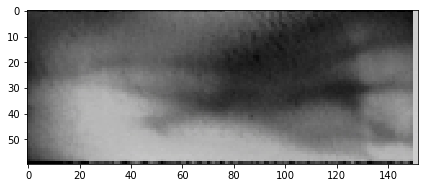

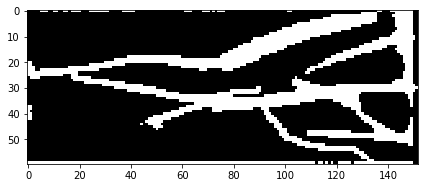

In [19]:
# 데이터 확인
ix = random.randint(0, len(train_ids))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()

In [20]:
y_train=np.expand_dims(y_train, axis=3)

In [21]:
y_train.shape

(1880, 60, 152, 1)

### 모델 및 평가지표

In [22]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

from tensorflow.python.keras.metrics import Metric
from keras import metrics
# Build U-Net model
inputs = Input((60, 152, 3))
s = Lambda(lambda x: x / 255) (inputs)
print(s)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
print("c1",c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
print("c1",c1)
p1 = MaxPooling2D((2, 2)) (c1)
print("p1",p1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
print("c2",c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
print("c2",c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
print("c3",c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
print("c3",c3)
p3 = MaxPooling2D((2, 2)) (c3)
print("p3",p3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.3) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c1])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = concatenate([u9, c1], axis=3)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
# c9 = Dropout(0.1) (c9)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c6)
#mIOU = tf.keras.metrics.MeanIoU(num_classes=20)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()
# 컨볼루션 레이어 더 쌓기/성능평가는 mean_iou(높을수록 좋음)/

Tensor("lambda_1/truediv:0", shape=(?, 60, 152, 3), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
c1 Tensor("conv2d_1/Elu:0", shape=(?, 60, 152, 16), dtype=float32)
c1 Tensor("conv2d_2/Elu:0", shape=(?, 60, 152, 16), dtype=float32)
p1 Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 30, 76, 16), dtype=float32)
c2 Tensor("conv2d_3/Elu:0", shape=(?, 30, 76, 32), dtype=float32)
c2 Tensor("conv2d_4/Elu:0", shape=(?, 30, 76, 32), dtype=float32)
c3 Tensor("conv2d_5/Elu:0", shape=(?, 30, 76, 64), dtype=float32)
c3 Tensor("conv2d_6/Elu:0", shape=(?, 30, 76, 64), dtype=float32)
p3 Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 15, 38, 64), dtype=float32)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
______________________________________________________________________

### 모델 시각화

In [48]:
!pip install pydot

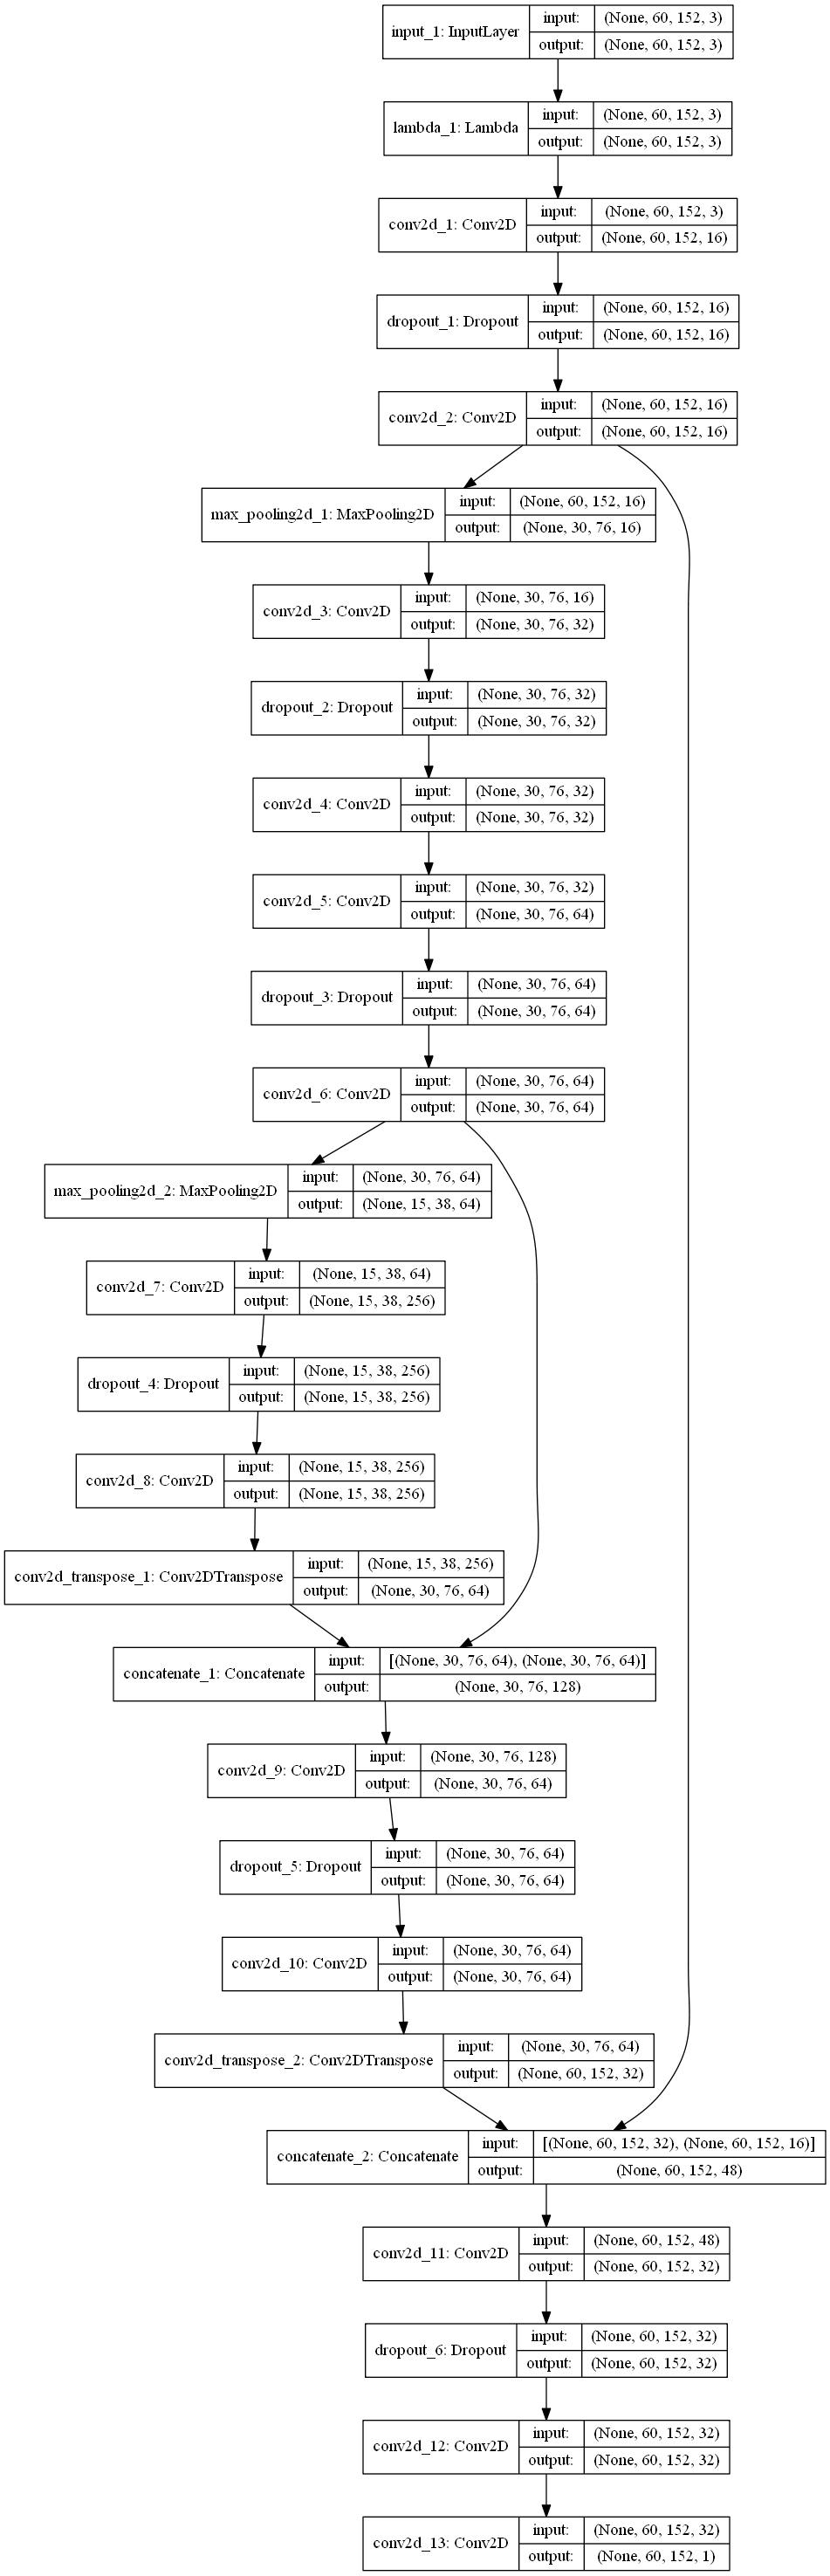

In [24]:
from keras.utils.vis_utils import plot_model
# import pydot
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
print(x_train.shape,y_train.shape,x_test.shape)

(1880, 60, 152, 3) (1880, 60, 152, 1) (600, 60, 152, 3)


In [24]:
mask_path=os.walk(MASK_TRAIN)
mask_ids = next(mask_path)[2]

In [25]:
mask_ids

['[SEG]강병준_1_1 - 복사본 (2).jpg',
 '[SEG]강병준_1_1 - 복사본 (3).jpg',
 '[SEG]강병준_1_1 - 복사본 (4).jpg',
 '[SEG]강병준_1_1 - 복사본 (5).jpg',
 '[SEG]강병준_1_1 - 복사본 (6).jpg',
 '[SEG]강병준_1_1 - 복사본 (7).jpg',
 '[SEG]강병준_1_1 - 복사본 (8).jpg',
 '[SEG]강병준_1_1 - 복사본 (9).jpg',
 '[SEG]강병준_1_1 - 복사본.jpg',
 '[SEG]강병준_1_1.jpg',
 '[SEG]강병준_2_1  - 복사본 (2).jpg',
 '[SEG]강병준_2_1  - 복사본 (3).jpg',
 '[SEG]강병준_2_1  - 복사본 (4).jpg',
 '[SEG]강병준_2_1  - 복사본 (5).jpg',
 '[SEG]강병준_2_1  - 복사본 (6).jpg',
 '[SEG]강병준_2_1  - 복사본 (7).jpg',
 '[SEG]강병준_2_1  - 복사본 (8).jpg',
 '[SEG]강병준_2_1  - 복사본 (9).jpg',
 '[SEG]강병준_2_1  - 복사본.jpg',
 '[SEG]강병준_2_1 .jpg',
 '[SEG]강병준_3_1  - 복사본 (2).jpg',
 '[SEG]강병준_3_1  - 복사본 (3).jpg',
 '[SEG]강병준_3_1  - 복사본 (4).jpg',
 '[SEG]강병준_3_1  - 복사본 (5).jpg',
 '[SEG]강병준_3_1  - 복사본 (6).jpg',
 '[SEG]강병준_3_1  - 복사본 (7).jpg',
 '[SEG]강병준_3_1  - 복사본 (8).jpg',
 '[SEG]강병준_3_1  - 복사본 (9).jpg',
 '[SEG]강병준_3_1  - 복사본.jpg',
 '[SEG]강병준_3_1 .jpg',
 '[SEG]강병준_4_1  - 복사본 (2).jpg',
 '[SEG]강병준_4_1  - 복사본 (3).jpg',
 '[SEG]강병준_4_1  - 복사본 (4).jp

In [26]:
def hangulFilePathImageRead3 (filePath ) :  
    stream = open( filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

In [27]:
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    train_= hangulFilePathImageRead3(MASK_TRAIN+id_)
    mask_=cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,19, 15) 
#     y_train.append(cv2.adaptiveThreshold(y_train_ids[i],255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,19,15))
    mask_= np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    #mask = np.maximum(mask, mask_)
    y_train[n] = mask_

100%|█████████████████████████████████████████████████████████████████████████████| 1880/1880 [00:02<00:00, 872.70it/s]


In [28]:
y_train.shape

(1880, 60, 152, 1)

### 학습

In [29]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=30, epochs=50, 
                    callbacks=[earlystopper,checkpointer])

Train on 1692 samples, validate on 188 samples
Epoch 1/50
1692/1692 [==============================] - 8s 4ms/step - loss: 0.5081 - mean_iou: 0.0627 - val_loss: 0.4809 - val_mean_iou: 0.1004

Epoch 00001: val_loss improved from inf to 0.48095, saving model to model-dsbowl2018-1.h5
Epoch 2/50
1692/1692 [==============================] - 4s 2ms/step - loss: 0.4475 - mean_iou: 0.1104 - val_loss: 0.4851 - val_mean_iou: 0.1178

Epoch 00002: val_loss did not improve from 0.48095
Epoch 3/50
1692/1692 [==============================] - 4s 2ms/step - loss: 0.4298 - mean_iou: 0.1222 - val_loss: 0.4490 - val_mean_iou: 0.1261

Epoch 00003: val_loss improved from 0.48095 to 0.44899, saving model to model-dsbowl2018-1.h5
Epoch 4/50
1692/1692 [==============================] - 4s 2ms/step - loss: 0.4205 - mean_iou: 0.1290 - val_loss: 0.4454 - val_mean_iou: 0.1317

Epoch 00004: val_loss improved from 0.44899 to 0.44537, saving model to model-dsbowl2018-1.h5
Epoch 5/50
1692/1692 [======================

### 테스트

In [30]:
sizes_test=[]
if __name__ == '__main__':
    for f in os.listdir(TEST_PATH):  
        if f.split('.')[1] =='jpg':
            filePath = (r"./unet_data/x_test_new/"+f)  
            sizes_test.append([hangulFilePathImageRead2(filePath).shape[0],hangulFilePathImageRead2(filePath).shape[1]])

In [31]:
print(np.array(sizes_test).shape)

(600, 2)


In [34]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.3).astype(np.uint8)
preds_val_t = (preds_val > 0.3).astype(np.uint8)
preds_test_t = (preds_test > 0.3).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

600/600 [==============================] - 1s 896us/step


In [36]:
print(y_train.shape)

(1880, 60, 152, 1)


### 결과 시각화

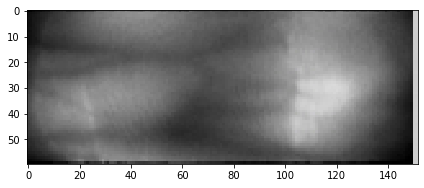

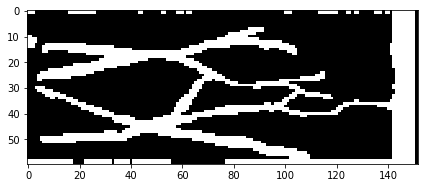

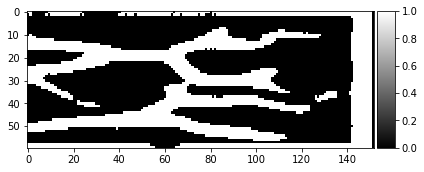

In [38]:
ix = random.randint(0, len(preds_train_t))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
# test는 어차피 위 사진과 상관없음
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

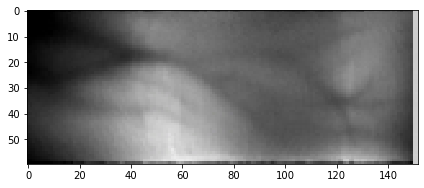

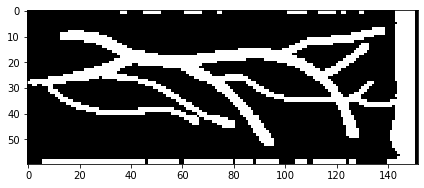

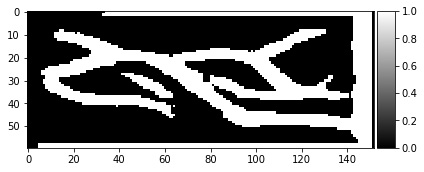

In [40]:
ix = random.randint(0, len(preds_val_t))
imshow(x_train[int(x_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
# val도 위 사진과 상관없음
imshow(np.squeeze(preds_val_t[ix]),cmap='gray')
plt.show()

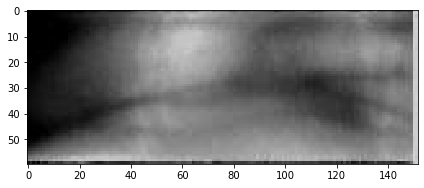

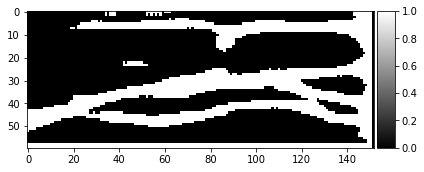

In [42]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_t))
imshow(x_test[ix])
plt.show()
# imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# plt.show()
a= np.squeeze(preds_test_t[ix])
imshow(np.squeeze(preds_test_t[ix]),cmap='gray')
plt.show()
# imshow(a,cmap='gray')
# plt.show()

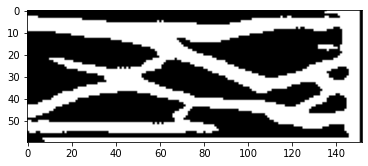

In [47]:
plt.imshow(np.squeeze(preds_test_t[0]),cmap='gray')

### 결과 저장

In [43]:
from skimage.io import imsave

x_test_name=[]
os.listdir(TEST_PATH).sort()
for f in os.listdir(TEST_PATH):  
    if f.split('.')[1] =='jpg' or f.split('.')[1]=='bmp':
#         print(f.split('.')[0])
        x_test_name.append(f.split('.')[0])

In [48]:
x_test_name

['[SEG]정대식_2_1',
 '[SEG]정대식_2_1_0_1496',
 '[SEG]정대식_2_1_0_229',
 '[SEG]정대식_2_1_0_2720',
 '[SEG]정대식_2_1_0_4373',
 '[SEG]정대식_2_1_0_442',
 '[SEG]정대식_2_1_0_5659',
 '[SEG]정대식_2_1_0_8028',
 '[SEG]정대식_2_1_0_8399',
 '[SEG]정대식_2_1_0_8538',
 '[SEG]정대식_3_1',
 '[SEG]정대식_3_1_0_1255',
 '[SEG]정대식_3_1_0_1910',
 '[SEG]정대식_3_1_0_2976',
 '[SEG]정대식_3_1_0_3487',
 '[SEG]정대식_3_1_0_389',
 '[SEG]정대식_3_1_0_4347',
 '[SEG]정대식_3_1_0_5047',
 '[SEG]정대식_3_1_0_6583',
 '[SEG]정대식_3_1_0_9537',
 '[SEG]정대식_4_1',
 '[SEG]정대식_4_1_0_2581',
 '[SEG]정대식_4_1_0_2593',
 '[SEG]정대식_4_1_0_3817',
 '[SEG]정대식_4_1_0_4067',
 '[SEG]정대식_4_1_0_4574',
 '[SEG]정대식_4_1_0_7242',
 '[SEG]정대식_4_1_0_7484',
 '[SEG]정대식_4_1_0_9122',
 '[SEG]정대식_4_1_0_9713',
 '[SEG]정대식_6_1',
 '[SEG]정대식_6_1_0_1303',
 '[SEG]정대식_6_1_0_1797',
 '[SEG]정대식_6_1_0_2138',
 '[SEG]정대식_6_1_0_238',
 '[SEG]정대식_6_1_0_4845',
 '[SEG]정대식_6_1_0_5737',
 '[SEG]정대식_6_1_0_6370',
 '[SEG]정대식_6_1_0_6998',
 '[SEG]정대식_6_1_0_7077',
 '[SEG]정대식_7_1',
 '[SEG]정대식_7_1_0_108',
 '[SEG]정대식_7_1_0_2091',
 '[SEG]정

In [51]:
for i in range(len(preds_test_t)):
    new_image=np.squeeze(preds_test_t[i])*255
    imsave(r'./unet_data/new/result/'+x_test_name[i]+'.jpg',new_image)

# -------------------------------------------------------

### 세선화 및 저장

In [53]:
#결과 가져오기
from PIL import Image
import glob
image_list = []
for filename in glob.glob('./unet_data/new/result/*.jpg'):   
    im=Image.open(filename)
    image_list.append(im)

In [55]:
print(len(image_list))

600


In [68]:
# 원본 가져오기
from PIL import Image
import glob
import numpy as np
from skimage.io import imsave
import os
image_list2 = []
name=[]

x_test_name=[]
os.listdir(TEST_PATH).sort()
for f in os.listdir(TEST_PATH):  
    if f.split('.')[1] =='jpg' or f.split('.')[1]=='bmp':
        x_test_name.append(f.split('.')[0])   #이미지 이름

In [70]:
for filename in glob.glob('./unet_data/x_test_new/*.jpg'): #원본가져오기(name이 append안됨. 왜?)
    im=Image.open(filename)
    image_list2.append(im)

In [72]:
image_array22=[]
for i in range(len(image_list2)):  
    image_array2 = np.asarray(image_list2[i]) #원본을 array로
    image_array2 = cv2.cvtColor(image_array2, cv2.COLOR_BGR2GRAY)  #image_array2가 비트사이즈가 24이므로 gray스케일로 바꿔줌.
    image_array22.append(image_array2)

In [62]:
def join(imagem,image_array2):#세선화, 원본
    image_array3=image_array2
    for i in range(0,60):
        for j in range(0,152):
            if(imagem[i][j]==True):  #정맥이면
                image_array3[i][j]=0
    return image_array3

In [64]:
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import filters
import cv2
from skimage.io import imsave
"load image data"
path='./unet_data/new/result'

    
def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0

        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned


In [79]:
# "Apply the algorithm on images"
for i in range(len(image_list)):
    image_array = np.asarray(image_list[i])  #결과를 array로 
    Img_Original = cv2.bitwise_not(image_array)  #흑백반전
    Otsu_Threshold = filters.threshold_otsu(Img_Original)   #Img_Original=np.array타입, (60.152)크기
    BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0 
    BW_Skeleton = zhangSuen(BW_Original)  #세선화(bool타입)
    
    
    image_array22[i].setflags(write=1)
#     plt.imshow(BW_Skeleton,cmap='gray')
    result=join(BW_Skeleton,image_array22[i])  #합치기(세선화, 원본)
#     plt.imshow(result,cmap='gray')
    imsave(r'./unet_data/new/thinning/'+x_test_name[i]+'.jpg',result)

In [85]:
# "Apply the algorithm on images"
for i in range(len(image_list)):
    image_array = np.asarray(image_list[i])  #결과를 array로 
    Img_Original = cv2.bitwise_not(image_array)  #흑백반전
    Otsu_Threshold = filters.threshold_otsu(Img_Original)   #Img_Original=np.array타입, (60.152)크기
    BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0 
    BW_Skeleton = zhangSuen(BW_Original)  #세선화(bool타입)
    result=BW_Skeleton * 255
#     print(result)
#     image_array22[i].setflags(write=1)
#     plt.imshow(BW_Skeleton,cmap='gray')
#     result=join(BW_Skeleton,image_array22[i])  #합치기(세선화, 원본)
#     plt.imshow(result,cmap='gray')
#     break
    imsave(r'./unet_data/new/thinning_only/'+x_test_name[i]+'.jpg',result)

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_2_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_2_1_0_1496.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_2_1_0_229.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_4_1_0_4574.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_4_1_0_7242.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_4_1_0_7484.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_8_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_8_1_0_1526.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]정대식_8_1_0_2232.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_2_1_0_7052.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_2_1_0_7781.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_2_1_0_9211.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_6_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_6_1_0_2162.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_6_1_0_250.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_8_1_0_6743.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_8_1_0_7590.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조철우_8_1_0_8878.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_2_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_2_1_0_1523.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_2_1_0_2313.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_4_1_0_4083.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_4_1_0_7335.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_4_1_0_8583.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_8_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_8_1_0_1071.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]조황원_8_1_0_1607.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_1_1_0_2922.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_1_1_0_4628.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_1_1_0_642.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_4_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_4_1_0_2379.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_4_1_0_3181.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_7_1_0_4027.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_7_1_0_4714.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]최현동_7_1_0_7469.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_1_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_1_1_0_1963.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_1_1_0_3120.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_3_1_0_3753.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_3_1_0_4849.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_3_1_0_4949.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_8_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_8_1_0_1740.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]한은정_8_1_0_1788.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_2_1_0_5532.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_2_1_0_7246.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_2_1_0_8199.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_6_9.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_6_9_0_1134.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_6_9_0_1644.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_8_9_0_6406.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_8_9_0_67.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]허환이_8_9_0_7694.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_2_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_2_1_0_3824.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_2_1_0_3832.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_4_1_0_3139.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_4_1_0_4813.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_4_1_0_5010.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_8_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_8_1_0_1702.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]현교환_8_1_0_3025.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_1_1_0_6069.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_1_1_0_818.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_1_1_0_8486.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_4_1.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_4_1_0_1414.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_4_1_0_1601.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1

C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_7_1_0_5143.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_7_1_0_6165.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\308_1\anaconda3\envs\JiMin\lib\site-packages\ipykernel_launcher.py:15: UserWarning: ./unet_data/new/thinning_only/[SEG]홍성용_7_1_0_7655.jpg is a low contrast image
  from ipykernel import kernelapp as app
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
C:\User

### 분기점 찾기 및 저장

In [131]:
from PIL import Image
import cv2
import numpy as np

def hangulFilePathImageRead2 (filePath ) :  
    stream = open( filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

In [132]:
def hangulFilePathImageRead (filePath ) :
    stream = open( filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_COLOR)  #3채널로 가져오기

In [161]:
import os

path='./unet_data/new/thinning_only/'
img_path_=os.walk(path)
img_path=next(img_path_)[2]

# train_path=os.walk(TRAIN_PATH) #raw
# train_ids= next(train_path)[2]


img_c=[]
img_g_=[]
if __name__ == '__main__':
#     print(img_path)
    for f in os.listdir(path):  
        filePath = (r'./unet_data/new/thinning_only/'+f)
        print(filePath)
        img_c.append(hangulFilePathImageRead(filePath))
        img_g_.append(hangulFilePathImageRead2(filePath))

./unet_data/new/thinning_only/[SEG]정대식_2_1.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_1496.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_229.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_2720.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_4373.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_442.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_5659.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_8028.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_8399.jpg
./unet_data/new/thinning_only/[SEG]정대식_2_1_0_8538.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1_0_1255.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1_0_1910.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1_0_2976.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1_0_3487.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1_0_389.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1_0_4347.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1_0_5047.jpg
./unet_data/new/thinning_only/[SEG]정대식_3_1_0_

./unet_data/new/thinning_only/[SEG]최현동_9_1.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_3064.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_4959.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_5396.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_5775.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_6086.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_8149.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_8242.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_8707.jpg
./unet_data/new/thinning_only/[SEG]최현동_9_1_0_967.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1_0_1963.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1_0_3120.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1_0_485.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1_0_4899.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1_0_5801.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1_0_605.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1_0_7363.jpg
./unet_data/new/thinning_only/[SEG]한은정_1_1_0_

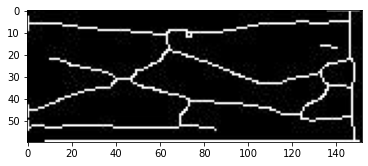

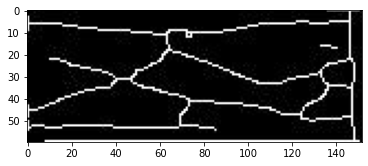

In [162]:
import matplotlib.pyplot as plt

plt.imshow(img_g_[0],cmap='gray')
plt.show()
plt.imshow(img_c[0])
plt.show()

In [163]:
print(len(img_c),len(img_g_),img_c[0].shape,img_g_[0].shape)

600 600 (60, 152, 3) (60, 152)


In [164]:
img_g_[0]

array([[  0,   6,   0, ..., 248, 255,   0],
       [  1,   0,   0, ...,  17,   0,  19],
       [  3,   9,   7, ...,  11,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,  19,   0],
       [  0,   0,   0, ...,  11,   0,   7],
       [  0,   0,   0, ..., 250, 255,   0]], dtype=uint8)

In [165]:
# img_g가 이진영상이 아니므로 다시 이진처리를 해줄것임 - 앞에서 dtype변환을 통해 저장하면 더 좋을듯
img_g=[]
for i in range(0,len(img_g_)):
    ret,img=cv2.threshold(img_g_[i],127,255,cv2.THRESH_BINARY_INV)
    img_g.append(img)
#     img_g[i]=img_g[i].shape[1]

In [166]:
img_g[0]

array([[255, 255, 255, ...,   0,   0, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ...,   0,   0, 255]], dtype=uint8)

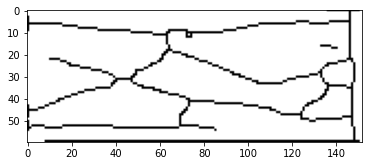

In [167]:
plt.imshow(img_g[0],cmap='gray')
plt.show()

In [169]:
from skimage.io import imsave

height,width=img_g[0].shape

for i in range(len(img_g)):
    for h in range(height-3): # padding
        for w in range(width-3):
            count=0
#             print(img[i][h][w])
            if img_g[i][h][w]==0:
                if img_g[i][h-1][w-1]==0 and img_g[i][h-1][w]==255: count=count+1
                if img_g[i][h-1][w]==0 and img_g[i][h-1][w+1]==255: count=count+1
                if img_g[i][h-1][w+1]==0 and img_g[i][h][w+1]==255: count=count+1
                if img_g[i][h][w+1]==0 and img_g[i][h+1][w+1]==255: count=count+1
                if img_g[i][h+1][w+1]==0 and img_g[i][h+1][w]==255: count=count+1
                if img_g[i][h+1][w]==0 and img_g[i][h+1][w-1]==255: count=count+1
                if img_g[i][h+1][w-1]==0 and img_g[i][h][w-1]==255: count=count+1
                if img_g[i][h][w-1]==0 and img_g[i][h-1][w-1]==255: count=count+1
            if count>=3:
                img_c[i][h][w][0]=255
                img_c[i][h][w][1]=0
                img_c[i][h][w][2]=0
                
                img_c[i][h+1][w][0]=255
                img_c[i][h+1][w][1]=0
                img_c[i][h+1][w][2]=0
                
                img_c[i][h-1][w][0]=255
                img_c[i][h-1][w][1]=0
                img_c[i][h-1][w][2]=0
                
                img_c[i][h][w+1][0]=255
                img_c[i][h][w+1][1]=0
                img_c[i][h][w+1][2]=0
                
                img_c[i][h][w-1][0]=255
                img_c[i][h][w-1][1]=0
                img_c[i][h][w-1][2]=0
#             if img_c[i][h][w][2]==255 and img_c[i][h-1][w-1][2]
    imsave(r'./unet_data/new/result_red/'+str(i)+'.jpg',img_c[i])

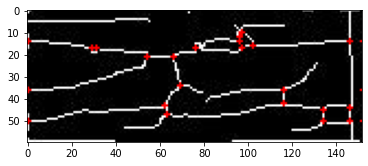

In [152]:
plt.imshow(img_c[400])
plt.show()

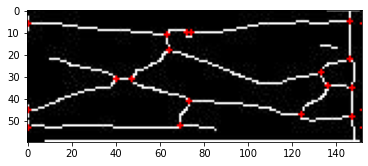

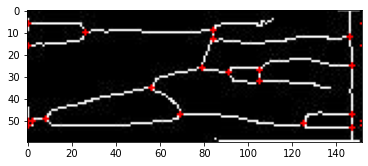

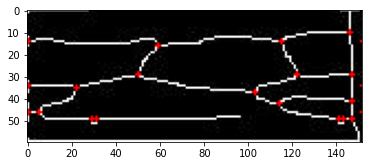

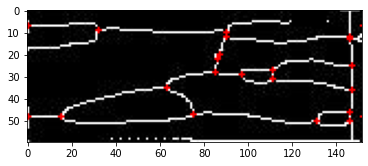

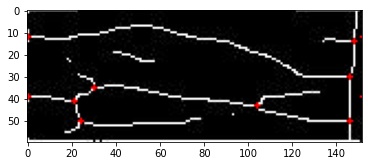

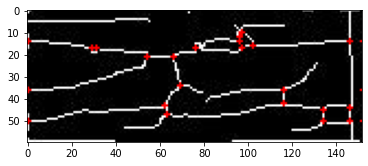

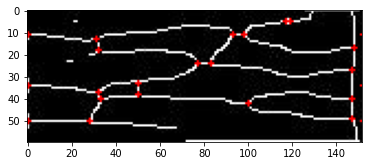

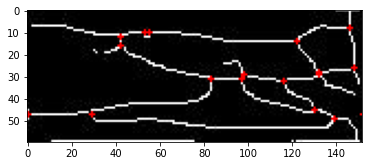

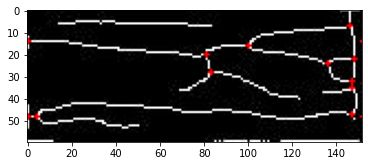

In [143]:
plt.imshow(img_c[0])
plt.show()
plt.imshow(img_c[40])
plt.show()
plt.imshow(img_c[60])
plt.show()
plt.imshow(img_c[48])
plt.show()
plt.imshow(img_c[300])
plt.show()
plt.imshow(img_c[400])
plt.show()
plt.imshow(img_c[450])
plt.show()
plt.imshow(img_c[50])
plt.show()
plt.imshow(img_c[577])
plt.show()